# Data Dive into NYC SBS LMI Zip Codes

In [109]:
# DS
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Webscraping
import requests
from bs4 import BeautifulSoup

# File reading
import io
import PyPDF2

# Text extraction
import re

# Exporting data
import pickle

## Zip Codes for Low and Moderate Income (LMI) Communities
- The eligible zip codes for the NYC Small Business Services program for LMI communities is available here:
https://www1.nyc.gov/assets/sbs/downloads/pdf/businesses/COVID19_LMI_Storefront_Loan_eligible_zipcodes.pdf

- Zip codes were extracted with regex

In [2]:
url = 'https://www1.nyc.gov/assets/sbs/downloads/pdf/businesses/COVID19_LMI_Storefront_Loan_eligible_zipcodes.pdf'
r = requests.get(url)
f = io.BytesIO(r.content)

In [3]:
pdf = PyPDF2.PdfFileReader(f)

In [4]:
num_pages = pdf.getNumPages()
print('Number of pages in PDF:', num_pages)

Number of pages in PDF: 4


In [5]:
# Extract eligible zip codes from PDF text
zip_codes = []
for n in range(num_pages):
    s = pdf.getPage(n).extractText()
    codes = re.findall(r'[0-9]{5}', s)
    zip_codes = zip_codes + codes

In [6]:
print('First 5 zip codes:', *zip_codes[:5])
print('Number of zip codes:', len(zip_codes))

First 5 zip codes: 10454 10453 10474 11212 10455
Number of zip codes: 139


## Median Income in NYC by Zip Code
- Median income by zip codes downloaded here: https://www.psc.isr.umich.edu/dis/census/Features/tract2zip/
    - Additional dependency: ```openpyxl```

- NYC zip codes taken from here:
https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

In [7]:
path = './MedianZIP-3.xlsx'
median_income = pd.read_excel(path, dtype='str', engine='openpyxl')

In [8]:
# Function to add truncated zeros at start of zip code
def add_zeros(x):
    if len(x) < 5:
        x = (5 - len(x)) * '0' + x
    return x

In [9]:
median_income['Zip'] = median_income['Zip'].map(add_zeros)

In [10]:
median_income.head(3)

,Zip,Median,Mean,Pop
0,01001,56662.5735,66687.7509,16445
1,01002,49853.4177,75062.6343,28069
2,01003,28462,35121,8491


In [11]:
url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'
r = requests.get(url)

In [12]:
soup = BeautifulSoup(r.text)

In [13]:
# Get zip codes from header3 table divisions
zc_lines = soup.find_all(attrs={'headers': 'header3'})
nyc_zc = [ zc.strip() for line in zc_lines for zc in line.text.split(',') ]

In [14]:
df = median_income.loc[median_income['Zip'].isin(nyc_zc)].reset_index(drop=True)
df.columns = [ col.lower() for col in df.columns ]
df.head(3)

,zip,median,mean,pop
0,10001,71244.61,123112.7764,17678
1,10002,30843.9574,46258.6118,70878
2,10003,89998.5339,139330.9968,53609


## Merge Data

In [15]:
df['eligible'] = np.where(df['zip'].isin(zip_codes), 1, 0)

In [16]:
# Percent zof NYC ip code eligible for program
df['eligible'].mean()

0.6022727272727273

In [17]:
# Convert data types
df = df.astype({
    'median': 'float',
    'mean': 'float',
    'pop': 'int',
})

In [18]:
# Descriptive stats of eligible vs. not eligible
df.groupby('eligible')['median'].describe()

,count,mean,std,min,25%,50%,75%,max
eligible,,,,,,,,
0,70.0,80844.157491,21439.600485,1520.1680,68170.43615,75485.72980,93553.168550,145458.7823
1,106.0,42503.716816,11993.381508,18024.1362,34748.75905,42574.52015,51466.398225,70964.8067


In [19]:
df.loc[df['median'] == df['median'].min()] # Zip Code: 10464, Pelham Bay

,zip,median,mean,pop,eligible
68,10464,1520.168,1673.4115,109,0


In [20]:
# Drop Pelham Bay
df.drop(68, inplace=True)

In [21]:
# DataFrame where median income of zip code is below maximum median income of eligible zip codes
missing_df = df.loc[
    (df['eligible'] == 0) &
    (df['median'] <= df.loc[df['eligible'] == 1]['median'].max())
]

## Geopandas Polygonal Data
- Polygonal data from: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-nation-u-s-2010-census-5-digit-zip-code-tabulation-area-zcta5-na
- Additional dependency: ```descartes```

In [56]:
# Read shapefiles
geo_df = gpd.read_file('./tl_2019_us_zcta510')

In [57]:
geo_df.head(3)

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,43452,B5,G6350,S,121522304,13721730,+41.5157923,-082.9809454,"POLYGON ((-83.08698 41.53780, -83.08256 41.537..."
2,43456,43456,B5,G6350,S,9320975,1003775,+41.6318300,-082.8393923,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."


In [77]:
nyc_geo = geo_df.loc[geo_df['ZCTA5CE10'].isin(nyc_zc)].copy()

In [78]:
nyc_geo.loc[nyc_geo['ZCTA5CE10'] == '10464'] # index 11275, drop Pelham Bay
nyc_geo.drop(11275, inplace=True)

In [79]:
set(nyc_geo['ZCTA5CE10']) - set(df['zip']) # missing zip code 11359, Fort Totten

{'11359'}

In [80]:
nyc_geo.loc[nyc_geo['ZCTA5CE10'] == '11359'] # index 14196
nyc_geo.drop(14196, inplace=True)

In [81]:
nyc_geo.rename(columns={'ZCTA5CE10': 'zip'}, inplace=True)

In [82]:
drop_cols = [ col for col in nyc_geo.columns if col not in ['zip', 'geometry'] ]

In [83]:
nyc_geo.drop(columns=drop_cols, inplace=True)

In [84]:
nyc_geo = pd.merge(nyc_geo, df, on='zip')
nyc_geo.set_index('zip', inplace=True)

In [85]:
nyc_geo.head()

,geometry,median,mean,pop,eligible
zip,,,,,
10065,"POLYGON ((-73.97210 40.76552, -73.97165 40.766...",108154.9505,191673.5228,31500,0
10075,"POLYGON ((-73.96469 40.77568, -73.96423 40.776...",112267.5519,188422.4971,25187,0
10128,"MULTIPOLYGON (((-73.93951 40.77922, -73.93957 ...",105186.9788,180473.0702,59434,0
10280,"POLYGON ((-74.01960 40.70564, -74.01955 40.706...",98937.8355,138990.0141,4298,0
10301,"MULTIPOLYGON (((-74.09460 40.61219, -74.09442 ...",56776.4674,75009.8666,38618,1


<AxesSubplot:>

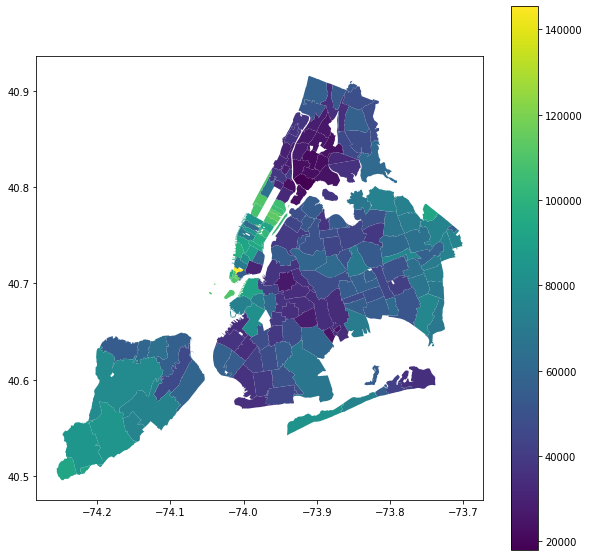

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
nyc_geo.plot(column='median', ax=ax, legend=True)

In [111]:
# with open('nyc_data.p', 'wb') as f:
#     pickle.dump(nyc_geo, f)

## Alternate Measures
- Income by FIPS/Community District: https://data.cccnewyork.org/data/download#0,8/66
- Geodata from: https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [112]:
path = '/Users/waynelam/Projects/nyc_sbs/med_income.csv'
fips_df = pd.read_csv(path)

In [136]:
path = './nycd_20d'
fips_geo = gpd.read_file(path)

In [139]:
fips_df.head()

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
0,New York City,All Households,2005,Dollars,56998.60927,3651000
1,New York City,Families,2005,Dollars,64793.69467,3651000
2,New York City,Families with Children,2005,Dollars,55448.77832,3651000
3,New York City,Families without Children,2005,Dollars,72309.25932,3651000
4,New York City,All Households,2006,Dollars,59080.75625,3651000


In [138]:
fips_geo.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,101,74168.587892,4.268912e+07,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,102,34130.595277,3.768921e+07,"POLYGON ((985125.733 207917.071, 986018.960 20..."
2,103,30695.640963,4.687978e+07,"POLYGON ((992073.467 203714.076, 992068.667 20..."
3,104,67623.669916,4.931172e+07,"POLYGON ((985929.324 220967.002, 985995.954 22..."
4,105,35288.188527,4.379033e+07,"POLYGON ((991725.244 217725.299, 992169.505 21..."


In [140]:
fips_geo.rename(columns={'BoroCD': 'Fips'}, inplace=True)

In [143]:
com_dist_df = pd.merge(fips_df, fips_geo, on='Fips')

In [145]:
# with open('cd_df.p', 'wb') as f:
#     pickle.dump(com_dist_df, f)